/tmp/ipykernel_1509248/3857614909.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(unique_labels))
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findf

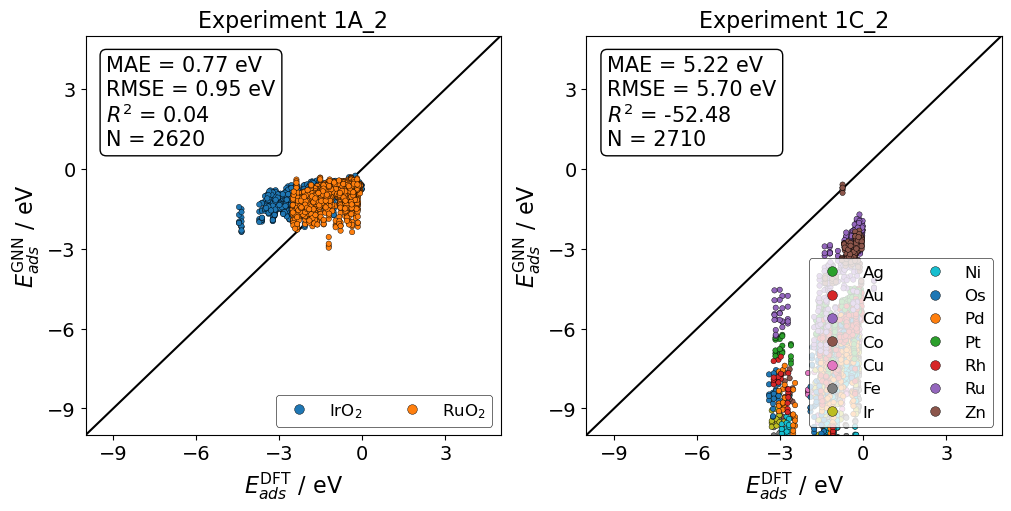

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from collections import defaultdict
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator

# Font config
arial_font = FontProperties(family='Arial', style='normal', size=11)

# Base directory
base_path = "/home/tvanhout/oxides_ML/models/Experiments/RELAXED/"
# experiments = [
#     "Experiment0/0A", "Experiment0/0B", "Experiment0/0C",
#     "Experiment1/1A", "Experiment1/1B", "Experiment1/1C",
#     "Experiment2/2A",
#     "Experiment3/3A", "Experiment3/3B", "Experiment3/3C"
# ]
# runs = ["run1", "run2", "run3", "run4", "run5"]
experiments = [
    "Experiment1/1A_2", "Experiment1/1C_2",
]
runs = ["run1", "run2", "run3", "run4", "run5"]

plt_path = "figures"
os.makedirs(plt_path, exist_ok=True)

# Map material names to LaTeX-style formatted labels
material_label_map = {
    "RuO2": r"$\mathrm{RuO_2}$",
    "TiO2": r"$\mathrm{TiO_2}$",
    "IrO2": r"$\mathrm{IrO_2}$"
    # Add more mappings if needed
}

# Matplotlib styling
plt.rcParams.update({
    "font.family": "Arial",
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 13
})


# === Part 1: Compute MAE Summary ===
summary_data = []

for experiment in experiments:
    maes = []
    for run in runs:
        csv_path = os.path.join(base_path, experiment, run, "test_set.csv")
        df = pd.read_csv(csv_path)
        mae = round(df["Abs_error_eV"].mean(), 2)
        maes.append(mae)
    short = experiment.split("/")[-1]
    summary_data.append({
        "Experiment": experiment,
        "Group": experiment.split("/")[0],
        "ShortLabel": short,
        "MAEs": maes,
        "MAE_Mean": round(np.mean(maes), 2),
        "MAE_Std": round(np.std(maes), 2)
    })

summary_df = pd.DataFrame(summary_data)
summary_csv_path = os.path.join(plt_path, "experiment_mae_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)

# === Part 2: Assign consistent color to ShortLabels (optional for barplots) ===
unique_labels = sorted(summary_df["ShortLabel"].unique())
color_map = cm.get_cmap('tab10', len(unique_labels))
label_colors = {label: color_map(i) for i, label in enumerate(unique_labels)}

# === Part 3: Parity Plots per Experiment Group ===

# Step 1: Collect all unique materials and apply mapping
material_set = set()
for exp in experiments:
    for run in runs:
        csv_path = os.path.join(base_path, exp, run, "test_set.csv")
        df = pd.read_csv(csv_path)
        df["Material"] = df["Material"].replace(material_label_map)  # apply mapping early
        material_set.update(df["Material"].unique())

material_list = sorted([m for m in material_set if isinstance(m, str)])
palette = dict(zip(material_list, sns.color_palette("tab10", n_colors=len(material_list))))

# Step 2: Group and plot
grouped_experiments = defaultdict(list)
for exp in experiments:
    group = exp.split("/")[0]
    grouped_experiments[group].append(exp)

for group_name, exp_list in grouped_experiments.items():
    n_exps = len(exp_list)
    fig, axs = plt.subplots(1, n_exps, figsize=(5 * n_exps, 5), constrained_layout=True)
    if n_exps == 1:
        axs = [axs]

    for idx, exp in enumerate(exp_list):
        all_dfs = []
        for run in runs:
            csv_path = os.path.join(base_path, exp, run, "test_set.csv")
            df = pd.read_csv(csv_path)
            all_dfs.append(df)

        df_concat = pd.concat(all_dfs, ignore_index=True)
        df_concat["Material"] = df_concat["Material"].replace(material_label_map)
        df_concat = df_concat.sort_values("Material")

        # Metrics
        y_true = df_concat["True_eV"]
        y_pred = df_concat["Prediction_eV"]
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        n = len(df_concat)

        ax = axs[idx]
        sns.scatterplot(
            x="True_eV", y="Prediction_eV", hue="Material",
            data=df_concat, ax=ax, ec="k", s=15, palette=palette
        )

        ax.set_title(f"Experiment {exp.split('/')[-1]}", fontsize=16)
        ax.set_ylabel(r'$E_{ads}^{\mathrm{GNN}}$ / eV')
        ax.set_xlabel(r'$E_{ads}^{\mathrm{DFT}}$ / eV')
        l_min, l_max = -10, 5
        ax.set_xlim(l_min, l_max)
        ax.set_ylim(l_min, l_max)
        ax.plot([l_min, l_max], [l_min, l_max], c="k", zorder=-1)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(5))

        # Text box with metrics
        text = "MAE = {:.2f} eV\nRMSE = {:.2f} eV\n$\mathit{{R}}^2$ = {:.2f}\nN = {}".format(mae, rmse, r2, n)
        props = dict(boxstyle='round', facecolor='white', edgecolor='black')
        ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=15,
                verticalalignment='top', bbox=props)

        # Legend formatting
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(
            handles, labels,
            loc="lower right",
            fontsize=12,
            ncol=2,
            markerscale=1.8  # <-- make legend dots larger
        )
        for text in legend.get_texts():
            text.set_text(text.get_text())  # No capitalization; already formatted
        legend.get_frame().set_linewidth(0.5)
        legend.get_frame().set_edgecolor("black")

    # Save figure
    fig_path = os.path.join(plt_path, f"{group_name}_parity_plots.png")
    fig.savefig(fig_path, dpi=300)
    plt.show()